Pymea Plotting Tutorial
=======================

First we have to load some external modules that will be used in processing and plotting data. This pipeline is intended to take a .csv file generated by `generate_spike_frequency_table.m` and produce plots for each experimental category contained in that experiment.

In [12]:
# Allows plots to appear on the notebook display
%matplotlib inline 
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
import pandas as pd
import numpy as np
import seaborn as sns
import itertools as it
from matplotlib import pyplot as plt

from pymea import plotting
from pymea import matlab_compatibility as mc

After importing modules, we load our dataset into a pandas DataFrame, `data_table`. The name of each column in this table corresponds to the unit name for that data in the format (well_row_letter)(well_col_number)(electrode_col_number)(electrode_row_number)(unit_number).

For example, the column titled `'B2312'` contains data for the second unit detected on electrode '31' of well 'B2'.

The exception is the `'time'` column, which contains a vector of strings corresponding to the date and time of each spike frequency time bin. This can be converted to python datetime objects (which can be supplied as an axis for plotting) using `matlab_compatibility.datetime_str_to_datetime`.

In [14]:
data_path = 'tutorial_data.csv'
data_table = pd.read_csv(data_path)
time_vector = data_table['time'].map(mc.datetime_str_to_datetime)

This raw form of data is clunky to use for plotting, and does not contain information corresponding to the experimental categories that units belong to. My solution to this is `plotting.construct_categorized_dataframe`.  `construct_categorized_dataframe` takes two arguments: `data_table`, which is the table we loaded above, and `filter_dict` a dictionary where keys are the names of each condition, and values are functions that return true for unit names that correspond to that condition, and false otherwise. The example data contains two conditions, and they were arranged on the maestro plate in a checkerboard pattern. Wells with an even row and an even column or an odd row and odd column were treated with ttx, and the remainder of the wells were not. To filter for these names, we make use of the convenient `matlab_compatibility.get_row_col_number_tuple` function, which takes a unit name as input and returns a tuple containing the row and column number for that unit. The filter function then checks if these numbers are both even, or both odd.

In [15]:
def is_even(num):
    return num % 2 == 0

def ttx_filter(name):
    row_num, col_num = mc.get_row_col_number_tuple(name)
    return (is_even(row_num) and is_even(col_num)) or not (is_even(row_num) or is_even(col_num))
    
def no_ttx_filter(name):
    row_num, col_num = mc.get_row_col_number_tuple(name)
    return(is_even(row_num) and not is_even(col_num)) or (not is_even(row_num) and is_even(col_num))

filter_dict = {
    'ttx': ttx_filter,
    'no_ttx': no_ttx_filter
    }

The categorized dataframe can then be constructed using the `data_table` and the `filter_dict`

In [16]:
cat_table = plotting.construct_categorized_dataframe(data_table, filter_dict)

In [17]:
cat_table.columns

Index([u'condition', u'spike_freq', u'time', u'unit_name'], dtype='object')

The categorized dataframe only has four columns: `'condition'`, `'spike_freq'`, `'time'` and `'unit_name'`. These can be easily queried to retrieve all of the data corresponding to a specific condition or unit name:

In [18]:
ttx_table = cat_table.query('condition == "ttx"')
a1222_table = cat_table.query('unit_name == "A1222"')

You can put queries such as these in a for loop. For example, to plot all of the unit traces in the ttx condition, you can iterate over the unit names in the ttx_table like this:

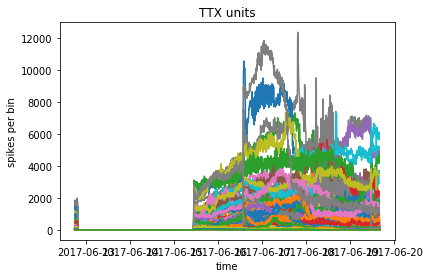

In [19]:
for unit_name in ttx_table['unit_name'].unique():
    unit_table = ttx_table.query('unit_name == @unit_name') # the @ symbol can be used inside of a query to access variables in the current scope
    plt.plot(unit_table['time'], unit_table['spike_freq'])
    
plt.title('TTX units')
plt.xlabel('time')
plt.ylabel('spikes per bin')

This plot looks a little funky since the pre and post ttx recordings took place on subsequent days. However, you can see that firing on all of the ttx wells ends at the end of the first recording (around 16:00:00), and is at 0 for the second recording (around 11:00:00 the following day). Plotting each trace in a dataframe of this format is something that you commonly want to do, so I wrapped the above for loop into a function `plotting.plot_unit_traces`:

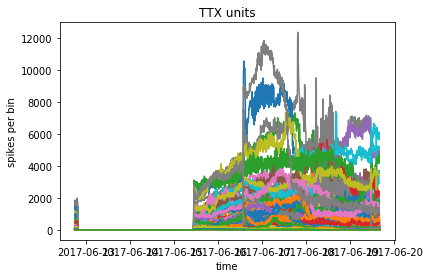

In [20]:
plotting.plot_unit_traces(ttx_table)
plt.title('TTX units')
plt.xlabel('time')
plt.ylabel('spikes per bin')

In many cases, firing rates have high frequency fluctuations on the order of minutes that distract from the slower trends in firing rate that we are interested in. The `plotting.smooth` function can be used in this cases to compute moving averages for each firing rate trace. For convenience, I created the `plotting.smooth_categorized_dataframe_unit_traces` function, which applies this to each unit in a categorized dataframe. Note that this creates small artifacts at the beginning and end of each recording due to edge conditions: 

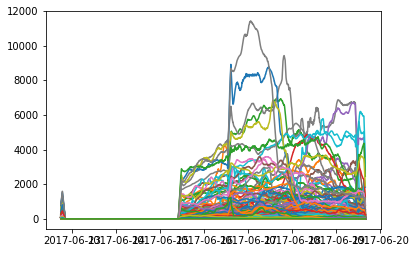

In [21]:
smooth_ttx = plotting.smooth_categorized_dataframe_unit_traces(ttx_table, kernel_size=20)
plotting.plot_unit_traces(smooth_ttx)

It is also often useful to look at the mean traces for each condition. I created the `plotting.plot_mean_frequency_traces` function for this purpose:

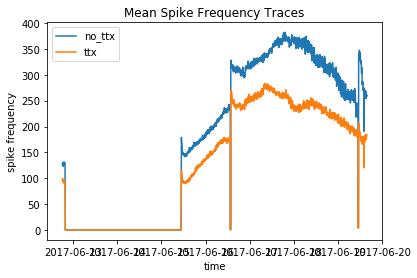

In [22]:
plotting.plot_mean_frequency_traces(cat_table)